In [48]:
################################
# Scientific imports
################################
import gc
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from astropy.io import fits
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy import units as u
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import TimeSeries
from astropy.stats import sigma_clipped_stats

################################
# General imports
################################
import csv, math, io, os, os.path, sys, random, time, json, statistics
import pandas as pd
import seaborn as sb
from tqdm.notebook import tqdm, trange

################################
# SciKitLearn Imports
################################
import sklearn
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import SpectralClustering
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

from IPython.display import display

################################
# MatPlotLib Settings
################################
plt.rcParams["figure.figsize"] = (16,4)
sb.set()

In [2]:
fitsList = np.load("fitslist.npy")

In [3]:
def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])       # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

j=LoadListGeneral("tsop301_planet_data.txt")
print(len(j))

6696


In [4]:
pl="tsop301_planet_data.txt"
sl="tsop301_star_data.txt"
ebl="tsop301_eb_data.txt"
bebl="tsop301_backeb_data.txt"

#starList = []
#planetList = []
#ebList = []
#bebList = []

In [5]:
def LoadListGeneral(f):
    lst=[]
    try:
        # Assuming everything CAN go well, do this
        with open('./SIM_DATA/unpacked/{}'.format(f)) as df:
            csvdf = csv.reader(df)
            for lineholder in csvdf:
                line = lineholder[0]                # I don't know why but this makes it work better
                if line[0]!="#":                    # Ignore commented lines (lines w/ FIRST STRING ELEMENT is a # character)
                    lst.append(line.split()[0])       # Add line to list
                # endif
            # endfor
        # endwith
    except FileNotFoundError:
        print("FNF")
        return
    # end try
    return lst

In [6]:
def LoadList(itemtype="all"):
    
    foundflag=False
    
    # itemtype = (S)tar, (P)lanet, (E)clipsing (B)inary, or (B)ack (E)clipsing (B)inary
    if itemtype.lower() in ["s", "star", "all"]:
        foundflag = True
        starList = list(map(int,LoadListGeneral(sl)))
        print("Loading star list: {}".format(sl))
    if itemtype.lower() in ["p", "planet", "all"]:
        foundflag = True
        planetList = list(map(int,LoadListGeneral(pl)))
        print ("loading planet list: {}".format(pl))
    if itemtype.lower() in ["eb", "eclipsing binary", "eclipsingbinary", "all"]:
        foundflag = True
        ebList = list(map(int,LoadListGeneral(ebl)))
        print ("loading eb list: {}".format(ebl))
    if itemtype.lower() in ["beb", "back eclipsing binary", "backeclipsingbinary", "all"]:
        foundflag = True
        bebList = list(map(int,LoadListGeneral(bebl)))
        print ("loading beb list: {}".format(bebl))
        
    if foundflag:
        #global alllists
        alllists = {"s": starList, "p": planetList, "eb": ebList, "beb": bebList}
        return (alllists)
    else:
        # If an invalid selection has been entered
        print("You must enter either:\n"
               "* \"S\" (or \"Star\")\n"
               "* \"P\" (or \"Planet\")\n"
               "* \"EB\" (or \"Eclipsing Binary\")\n"
               "* \"BEB\" (or \"Back Eclipsing Binary\")")


In [7]:
def IsThisAStar(n):
    return n in alllists["s"]
    
def IsThisAPlanet(n):
    return n in alllists["p"]

def IsThisAEB(n):
    return n in alllists["eb"]

def IsThisABEB(n):
    return n in alllists["beb"]

# Function to tell you what an item is
def WhatIsMyLC(n):
    lbl = []
    lbl.append("Star") if IsThisAStar(n) else lbl
    lbl.append("Planet") if IsThisAPlanet(n) else lbl
    lbl.append("EB") if IsThisAEB(n) else lbl
    lbl.append("BRB") if IsThisABEB(n) else lbl
    
    return "UNKNOWN" if lbl==[] else lbl

# Purely for convenience
def CurrentLC():
    return ("File № {} - {}".format(lastRandom["number"], lastRandom["id"]))

In [8]:
alllists = LoadList()

Loading star list: tsop301_star_data.txt
loading planet list: tsop301_planet_data.txt
loading eb list: tsop301_eb_data.txt
loading beb list: tsop301_backeb_data.txt


In [9]:
starList, planetList, ebList, bebList = alllists['s'], alllists['p'], alllists['eb'], alllists['beb']

In [10]:
def DrawACurve(n=None):
    rndFile = random.randint(0,len(fitsList)) if n == None else n
    fitsFile = fitsList[rndFile]
    
    # The following line of code gives us the header values
    fitsHeaders = fits.getheader(fitsFile)

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the fit parameters for the first TCE.  These are stored in the FITS header of the first
        # extension.
        duration = (hdulist[1].header['LIVETIME'])

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    # Start figure and axis.
    fig, ax = plt.subplots()

    # Plot the timeseries in black circles.
    ## Using the [1:-1] identifier to cut off the leading and trailing zeroes

    ax.plot(tess_bjds[1:-1], pdcsap_fluxes[1:-1], 'k.', markersize=1)

    # Let's label the axes and define a title for the figure.
    fig.suptitle("File № {} - {}".format(rndFile,obj))
    ax.set_ylabel("PDCSAP Flux (e-/s)")
    ax.set_xlabel("Time (TBJD)")

    # Adjust the left margin so the y-axis label shows up.
    plt.subplots_adjust(left=0.15)
    #plt.figure(figsize=(2,8))
    plt.show()

In [11]:
def DrawLC(N=-1):
    rndFile = random.randint(0,len(fitsList))
    #print("FILE IS {}".format(rndFile))
    #fileNum = fitsList[rndFile]
    fitsFile = fitsList[rndFile] if N==-1 else fitsList[N]

    with fits.open(fitsFile, mode="readonly") as hdulist:

        # Extract stellar parameters from the primary header.  We'll get the effective temperature, surface gravity,
        # and TESS magnitude.
        obj = hdulist[0].header['OBJECT']
        sector = hdulist[0].header['SECTOR']

        # Extract some of the columns of interest for the first TCE signal.  These are stored in the binary FITS table
        # in the first extension.  We'll extract the timestamps in TBJD, phase, initial fluxes, and corresponding
        # model fluxes.
        tess_bjds = hdulist[1].data['TIME']
        pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']

    return (tess_bjds[1:-1], pdcsap_fluxes[1:-1], str(rndFile), str(obj), str(sector))

In [12]:
MASTERCURVE = 10279

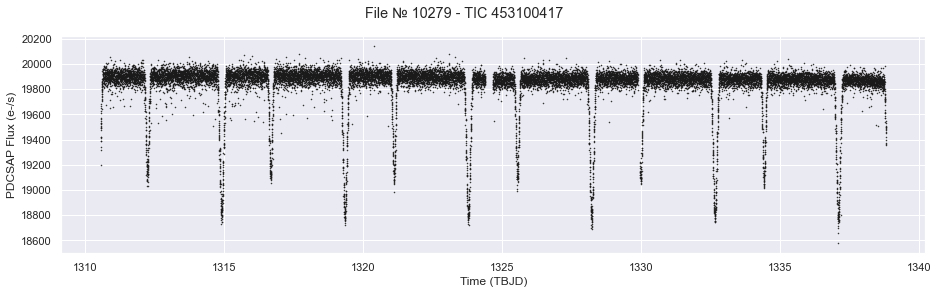

In [50]:
DrawACurve(MASTERCURVE)

In [15]:
TICList = [0]*len(fitsList)

In [17]:
# Make a list of EVERY TIC IN ORDER
for i in range(len(fitsList)):
    with fits.open(fitsList[i], mode="readonly") as hdulist:
        obj = hdulist[0].header['OBJECT']
        TICList[i] = int(obj.split('TIC ')[1])

Now that I have an ORDERD TICList of items, time to confirm whether or not a thing is a planet!

In [18]:
isPlanetList = [0]*len(TICList)
isEbList = [0]*len(TICList)
isBebList = [0]*len(TICList)
isStarList = [0]*len(TICList)

In [19]:
# Time to do many loops

for i in range(len(TICList)):
    # The isPlanetList defaults to zero; check if TICList[i] is in plist
    OBJ = TICList[i]
    
    if OBJ in planetList:
        isPlanetList[i] = i
        # isPlanetList[i] = [OBJ, planetList.index(OBJ)]
        
    if OBJ in ebList:
        isEbList[i] = i
        # isEbList[i] = [OBJ, ebList.index(OBJ)]
        
    if OBJ in bebList:
        isBebList[i] = i
        # isBebList[i] = [OBJ, bebList.index(OBJ)]
        
    if OBJ in starList:
        isStarList[i] = i
        # isStarList[i] = [OBJ, starList.index(OBJ)]

In [20]:
isPlanetListShort = [i for i in isPlanetList if i != 0]
isEbListShort     = [i for i in isEbList     if i != 0]
isBebListShort    = [i for i in isBebList    if i != 0]
isStarListShort   = [i for i in isStarList   if i != 0]

In [21]:
tstFile = random.choice(isPlanetListShort)
X = TICList[tstFile]
print(tstFile)
print(X)

4351
388200275


Our TIC code is 388200275!
Is it A:
* Planet? - True
* EB?     - False
* BEB?    - False
* Star?   - False


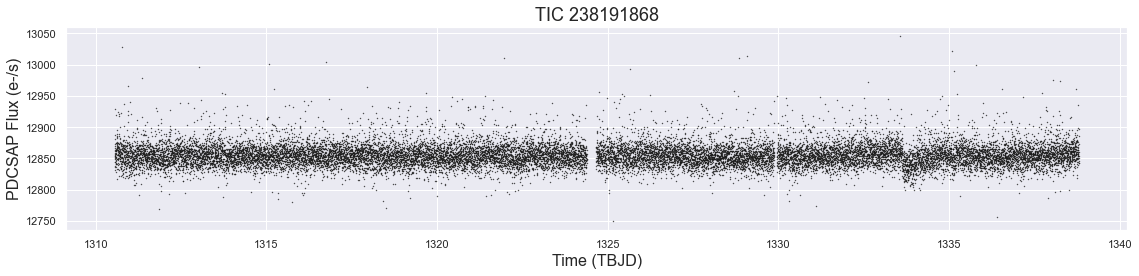

In [52]:
x,y,f,o,s = DrawLC(tstFile)

#base_x = x[0]
#x[:] = [number - base_x for number in x]
#x

plt.plot(x,y,'k.',markersize=0.75)
plt.xlabel("Time (TBJD)", fontsize=16)
plt.ylabel("PDCSAP Flux (e-/s)", fontsize=16)
plt.title("{}".format(o), fontsize=18)

#plt.ylim([79900,80400])

plt.tight_layout()
#plt.savefig('img/rndplanet12.png')

print("Our TIC code is {}!\n"
      "Is it A:\n"
     "* Planet? - {}\n"
     "* EB?     - {}\n"
     "* BEB?    - {}\n"
     "* Star?   - {}".format(X, (X in planetList), (X in ebList), (X in bebList), (X in starList)))

In [25]:
uniqueP    = list(set(planetList))
uniqueEB   = list(set(ebList))
uniqueBEB  = list(set(bebList))
uniqueSTAR = list(set(starList))

numP    = len(uniqueP)
numEB   = len(uniqueEB)
numBEB  = len(uniqueBEB)
numSTAR = len(uniqueSTAR)
numSTAR = len(fitsList) - numP - numEB - numBEB

numStuff   = numP + numEB + numBEB + numSTAR
#noise      = len(fitsList) - numStuff
dataSpread = [numP, numEB, numBEB, numSTAR] #, noise]

In [26]:
numP    = len(planetList)
numEB   = len(ebList)
numBEB  = len(bebList)
numSTAR = len(starList)
dataSpread = [numP, numEB, numBEB, numSTAR]

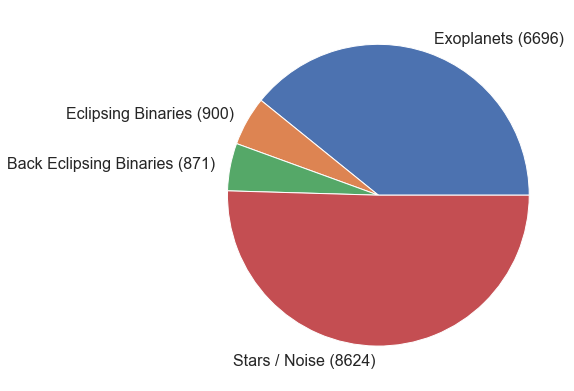

In [185]:
mylabels = ["Exoplanets ({})".format(numP),
            "Eclipsing Binaries ({})".format(numEB),
            "Back Eclipsing Binaries ({})".format(numBEB),
            "Stars / Noise ({})".format(numSTAR)] 
plt.rcParams["figure.figsize"] = (8,8)
plt.pie(dataSpread, labels=mylabels, textprops={'fontsize': 16}, startangle=0)
plt.rcParams["figure.figsize"] = (16,4)
#plt.show()
plt.tight_layout()
plt.savefig('img/dataspread.png')

In [28]:
len(planetList)

6696

In [29]:
len(uniqueP)

3146

In [30]:
defaultText = """
\\begin{figure}[H]
    \\centering
    \\includegraphics[width=1\\linewidth]{FILENAME}
    \\caption{CAPTION}
    \\label{fig:FIGNAME} 
\\end{figure}"""
#print(defaultText) 

In [31]:
for loopnum in range(10):
    imgfname = "rndstar{:02d}".format(loopnum+1)
    imgcaption = "A sample light curve of an observation with confirmed exoplanet status."
    imglabel = "fig:{}".format(imgfname)
    
    newtxt = defaultText.replace("FILENAME",imgfname).replace("CAPTION",imgcaption).replace("FIGNAME",imglabel)
    
    print(newtxt)


\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{rndstar01}
    \caption{A sample light curve of an observation with confirmed exoplanet status.}
    \label{fig:fig:rndstar01} 
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{rndstar02}
    \caption{A sample light curve of an observation with confirmed exoplanet status.}
    \label{fig:fig:rndstar02} 
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{rndstar03}
    \caption{A sample light curve of an observation with confirmed exoplanet status.}
    \label{fig:fig:rndstar03} 
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{rndstar04}
    \caption{A sample light curve of an observation with confirmed exoplanet status.}
    \label{fig:fig:rndstar04} 
\end{figure}

\begin{figure}[H]
    \centering
    \includegraphics[width=1\linewidth]{rndstar05}
    \caption{A sample light curve of an observation wit

In [133]:
# Making arrays of all the data I need
numPics = 10
deviation = 0
lcArray = [0]*numPics #np.zeros((numPics,5))

for ctr in range (numPics):
    # Set up random info if needed
    tstFile = random.choice(isPlanetListShort)
    
    # Get the info
    x,y,f,o,_ = DrawLC(tstFile)
    
    # Stabdardise the Time Series (x co-ords)
    x[:] = [number - 1310 for number in x]
    
    # Normalise the Flux (y co-ords)
    mean = np.mean(y)
    y[:] = [(number/mean)+(0.1*ctr) for number in y]
    
    # Update deviation
    dif = max(y)-min(y)
    #print("Deviation is {}".format(dif))
    deviation = dif if dif > deviation else deviation
    
    # Add to list
    lcArray[ctr] = [x,y,f,o]

#print("Maximum deviation is {}".format(deviation))
deviation = math.ceil((deviation * 10))/10
print("Maximum deviation is {}".format(deviation))

In [135]:
for ctr in range (numPics):
    # Offset Y so I can plot them all at once
    lcArray[ctr][1] = [number + (ctr/numPics) for number in lcArray[ctr][1]]
    
# Now I have a list of 10 random LCs

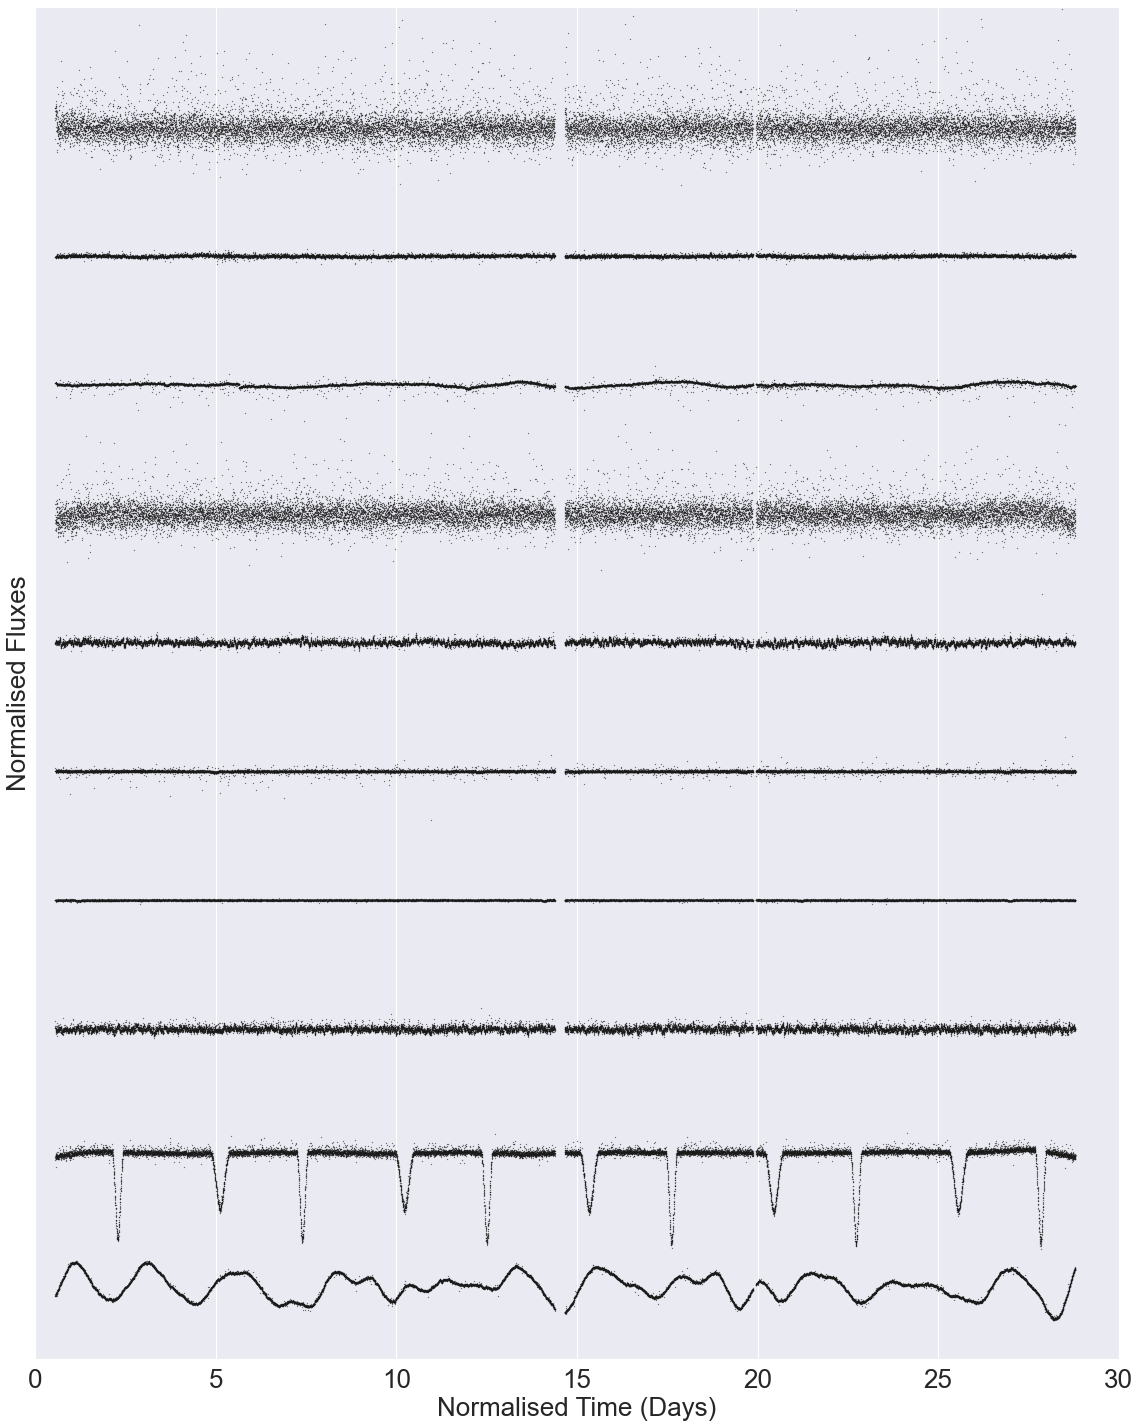

In [187]:
for i in range(len(lcArray)):
    plt.rcParams["figure.figsize"] = (16,20)
    plt.plot(lcArray[i][0], lcArray[i][1], 'k.', markersize=0.5)

#legendList = [x[3] for x in lcArray]
#legendList.reverse()
#plt.legend(legendList, loc=7, fontsize=15, handlelength=0, handletextpad=0, labelspacing = 5.9) #, ncol=5)

plt.xlim([0,30])
plt.ylim([0.9,3])
plt.xticks(fontsize=26)
plt.yticks([])
plt.xlabel("Normalised Time (Days)", fontsize=26)
plt.ylabel("Normalised Fluxes", fontsize=26)
#plt.title("10 LILITH-4 Light Curves of 28 day observations of confirmed exoplanets", fontsize=26)
#plt.grid(b=None)
plt.tight_layout()
plt.savefig("img/10LCsPlanets_02.png")

plt.rcParams["figure.figsize"] = (16,4)

TIC 277070297


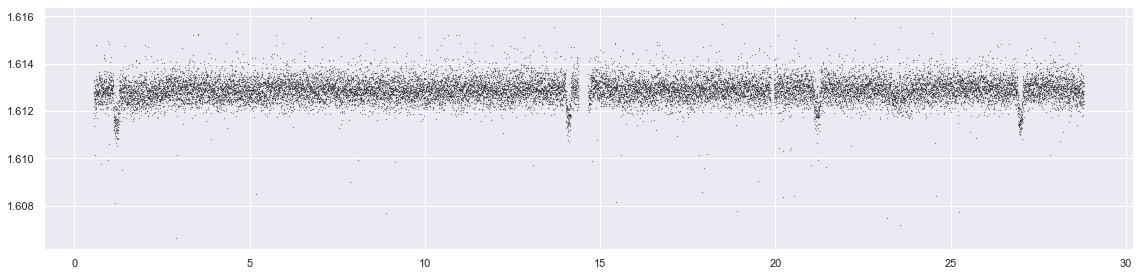

In [189]:
plt.plot(lcArray[3][0], lcArray[3][1], 'k.', markersize=0.4)
plt.tight_layout()
plt.savefig("img/10LCsPlanets_3rd_lc_zoomed.png")
print(lcArray[3][3])